In [48]:
"""Data loading tools"""
import yaml
import pandas as pd


def read_config(file_path='./config.yaml'):
    """Reads configuration file
    Args:
        file_path (str, optional): file path
    Returns:
        dict: Parsed configuration file
    """
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

def get_data(file_path=None, nrows=None):
    """Loads data
    Args:
        file_path (str, optional): file path of dataset
            By default load data set from static web page
        nrows (int, optional): number or rows to loads from dataset
            By default loads all dataset  
    Returns:
        dataframe: output dataframe
    """
    if file_path is None:
        cfg = read_config()
        file_path = cfg['paths']['eng_dataset']
    print("Reading dataset ...")    
    return pd.read_csv(file_path,sep="\t", encoding="utf-8",
                       nrows=nrows, low_memory=False)

if __name__ == "__main__":
    data = get_data(file_path = "/content/drive/MyDrive/ECOLE/Machine Learning/df_withoutduplicatefeatures4.csv", nrows=20000)
    print(f"data set shape is {data.shape}") 

Reading dataset ...
data set shape is (20000, 165)


In [2]:
print(data.columns.tolist()) 

['code', 'url', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging_en', 'packaging_text', 'brands', 'categories_en', 'origins_en', 'manufacturing_places', 'labels_en', 'emb_codes', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries_en', 'ingredients_text', 'ingredients_analysis_tags', 'allergens', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutrition_data', 'additives_n', 'additives_en', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'food_groups_en', 'states_en', 'brand_owner', 'ecoscore_score', 'ecoscore_grade', 'nutrient_levels_tags', 'product_quantity', 'owner', 'data_quality_errors_tags', 'unique_scans_n', 'popularity_tags', 'completeness', 'main_category_en', 'image_small_url', 'image_ingredients_small_url', 'image_nutrition_small_url', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'butyric-acid_100g', '

In [49]:
# Import des bibliothèques nécessaires
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# Étape 1 : Nettoyage des données
# Suppression des entrées avec des valeurs manquantes
#data.dropna(inplace=True) pas fait car cela supprime toutes les lignes mais à voir 
# Suppression des lignes où 'fat_100g' > 100 car impossible ainsi que energy > 15000 car 1 outlier genant dans la viz
data = data[data['fat_100g'] <= 100]
data = data[data['energy_100g'] <= 15000]

# Étape 2 : Normalisation des valeurs nutritionnelles
# Conversion des valeurs nutritionnelles en float
data['nutrition-score-fr_100g'] = pd.to_numeric(data['nutrition-score-fr_100g'], errors='coerce')
# Remplacement des valeurs aberrantes par des valeurs nulles
data['nutrition-score-fr_100g'].where((data['nutrition-score-fr_100g'] >= -15) & (data['nutrition-score-fr_100g'] <= 40), inplace=True)

# Étape 3 : Gestion des catégories d'ingrédients
# Fusion des catégories similaires
data['categories_en'] = data['categories_en'].replace({'en:snacks':'snacks', 'en:beverages':'beverages', 'en:dairies':'dairies'})
# Création de nouvelles catégories agrégées
data['categories_en'] = data['categories_en'].apply(lambda x: 'other' if x not in ['snacks', 'beverages', 'dairies'] else x)

# Étape 4 : Sélection des caractéristiques
# Élimination des variables redondantes et pas interessant dans le clustering
data.drop(['code', 'url', 'brands'], axis=1, inplace=True)

# Étape 5 : Encodage des variables catégorielles
# Encodage one-hot de la variable catégorielle 'categories_en'
encoder = OneHotEncoder()
categories_encoded = encoder.fit_transform(data[['categories_en']])
data = pd.concat([data, pd.DataFrame(categories_encoded.toarray(), columns=encoder.get_feature_names_out(['categories_en']))], axis=1)
data.drop(['categories_en'], axis=1, inplace=True)

# Étape 6 : Split des données
from sklearn.model_selection import train_test_split
X = data.drop(['nutrition-score-fr_100g'], axis=1)
y = data['nutrition-score-fr_100g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Remplacer les valeurs non numériques par des valeurs manquantes
data.replace(to_replace=['kiliweb', 'additives_n'], value=np.nan, inplace=True)

# Remplacer les valeurs manquantes par la moyenne des valeurs existantes pour chaque colonne
data.fillna(data.mean(), inplace=True)

# Sélection et préparation des données pour le clustering
X = data[['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g','sodium_100g','sugars_100g','calcium_100g']]

# Implémentation des méthodes de clustering
kmeans = KMeans(n_clusters=3)
agglo = AgglomerativeClustering(n_clusters=3)
dbscan = DBSCAN(eps=0.1)

# Entraînement des modèles de clustering
kmeans.fit(X)
agglo.fit(X)
dbscan.fit(X)

# Affichage des résultats
print("KMeans labels:", kmeans.labels_)
print("AgglomerativeClustering labels:", agglo.labels_)
print("DBSCAN labels:", dbscan.labels_)


<ipython-input-51-5f42ed068fd4>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans labels: [0 0 1 ... 1 1 1]
AgglomerativeClustering labels: [1 1 0 ... 0 0 0]
DBSCAN labels: [ -1  -1  -1 ... 252 252 252]


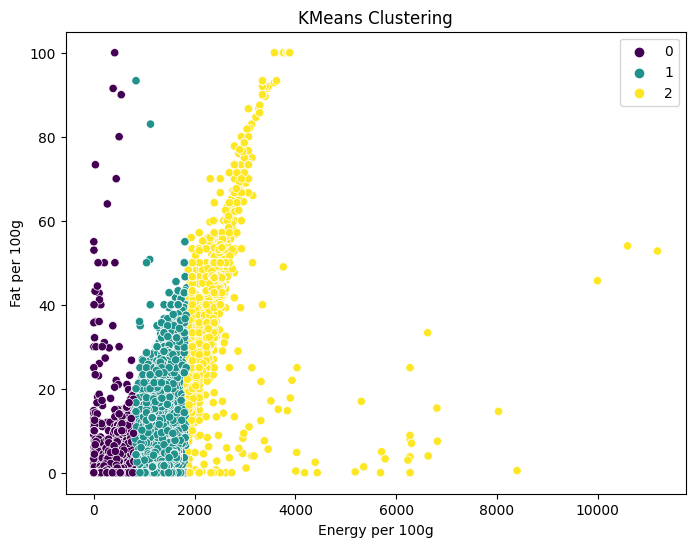

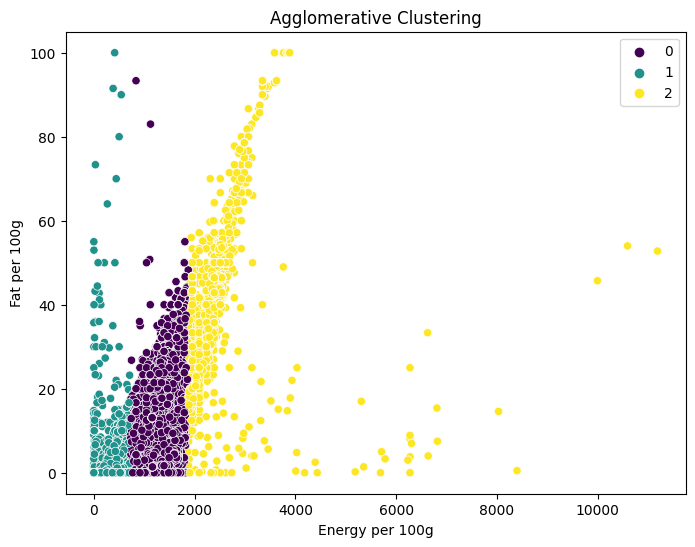

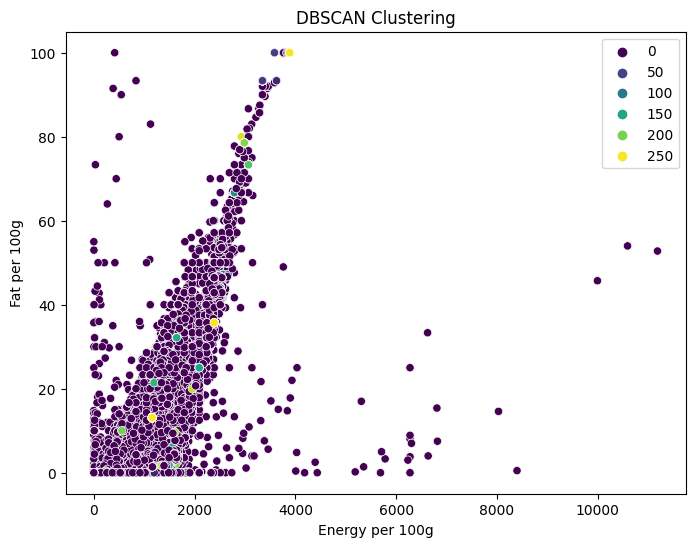

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création des graphiques pour KMeans
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['energy_100g'], y=X['fat_100g'], hue=kmeans.labels_, palette='viridis')
plt.title('KMeans Clustering')
plt.xlabel('Energy per 100g')
plt.ylabel('Fat per 100g')
plt.show()

# Création des graphiques pour AgglomerativeClustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['energy_100g'], y=X['fat_100g'], hue=agglo.labels_, palette='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Energy per 100g')
plt.ylabel('Fat per 100g')
plt.show()

# Création des graphiques pour DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['energy_100g'], y=X['fat_100g'], hue=dbscan.labels_, palette='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Energy per 100g')
plt.ylabel('Fat per 100g')
plt.show()
